# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Data

In [2]:
from darts import TimeSeries

df = pd.read_csv('../csv/Ming1Jul67_total_order.csv')
df.tail()

,order_completed_at,unique_order_count
543,2024-06-27,145
544,2024-06-28,142
545,2024-06-29,126
546,2024-06-30,161
547,2024-07-01,142


In [3]:
df.head()

,order_completed_at,unique_order_count
0,2023-01-01,15
1,2023-01-02,32
2,2023-01-03,89
3,2023-01-04,73
4,2023-01-05,67


In [94]:
df.shape

(541, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_completed_at  548 non-null    object
 1   unique_order_count  548 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ KB


In [5]:
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])

In [6]:
# make timeseries Object
series = TimeSeries.from_dataframe(df,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                   freq="D")

# Viusalize Data

### plot import data

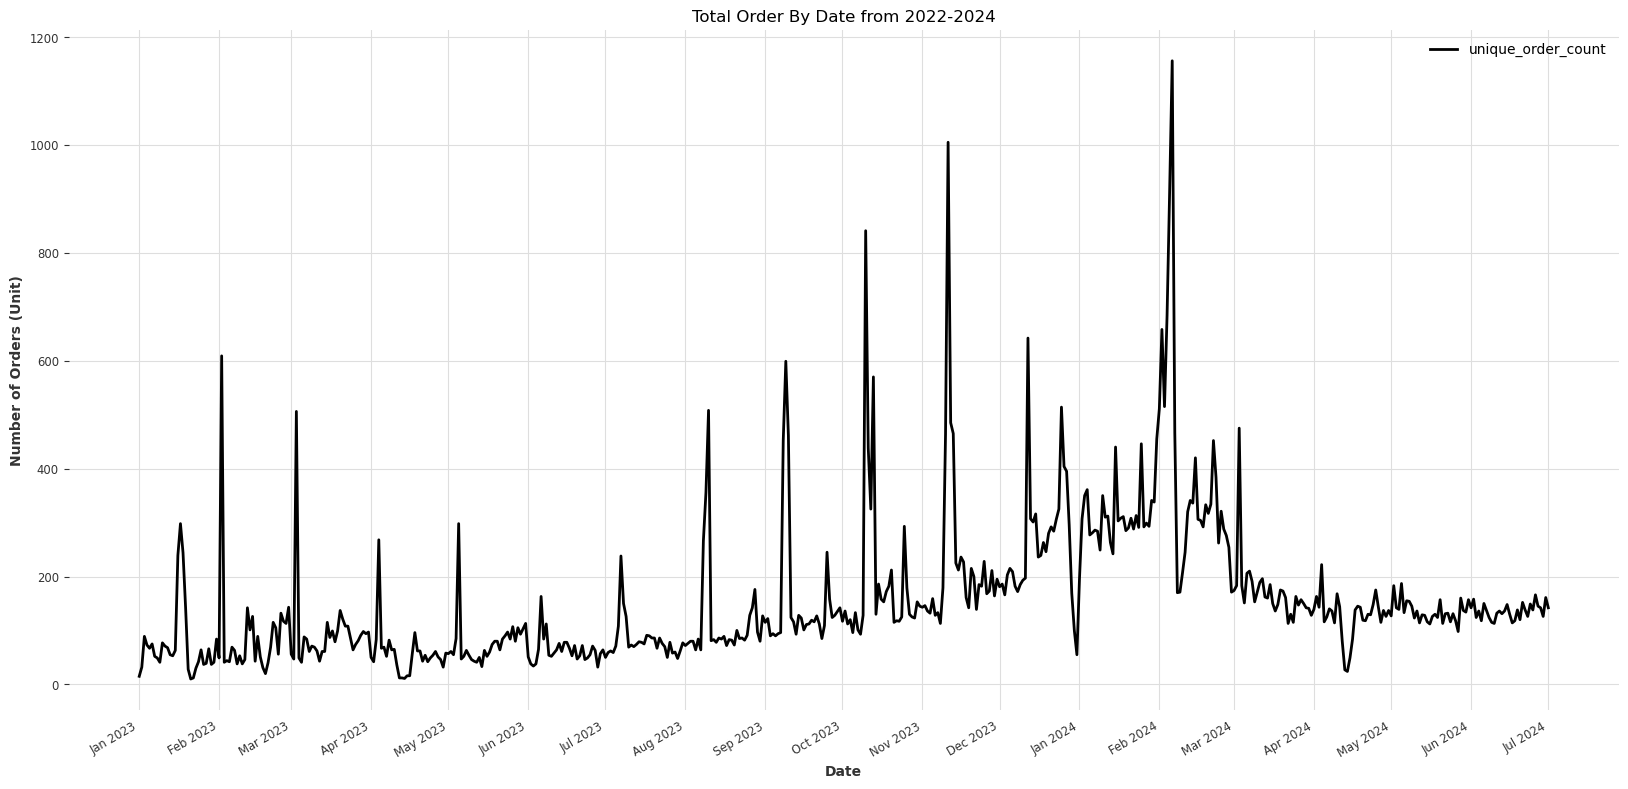

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(20, 10)) 
series.plot()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate() 

plt.title('Total Order By Date from 2022-2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders (Unit)')

plt.show()

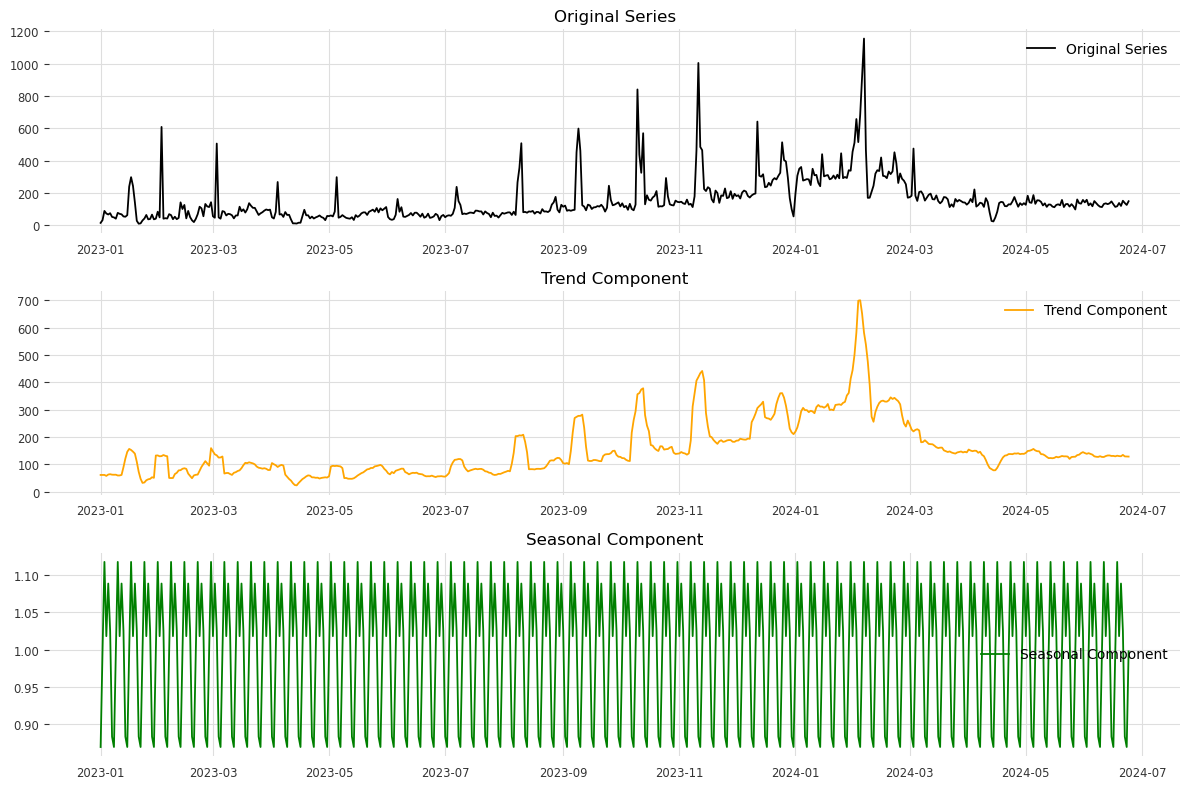

In [16]:
from darts.utils.statistics import extract_trend_and_seasonality
trends , seasonal = extract_trend_and_seasonality(series)


# Plot the results
plt.figure(figsize=(12, 8))

# Original series
plt.subplot(3, 1, 1)
plt.plot(series.time_index, series.values(), label='Original Series')
plt.title('Original Series')
plt.legend()

# Trend component
plt.subplot(3, 1, 2)
plt.plot(trends.time_index, trends.values(), label='Trend Component', color='orange')
plt.title('Trend Component')
plt.legend()

# Seasonal component
plt.subplot(3, 1, 3)
plt.plot(seasonal.time_index, seasonal.values(), label='Seasonal Component', color='green')
plt.title('Seasonal Component')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

### stationary test

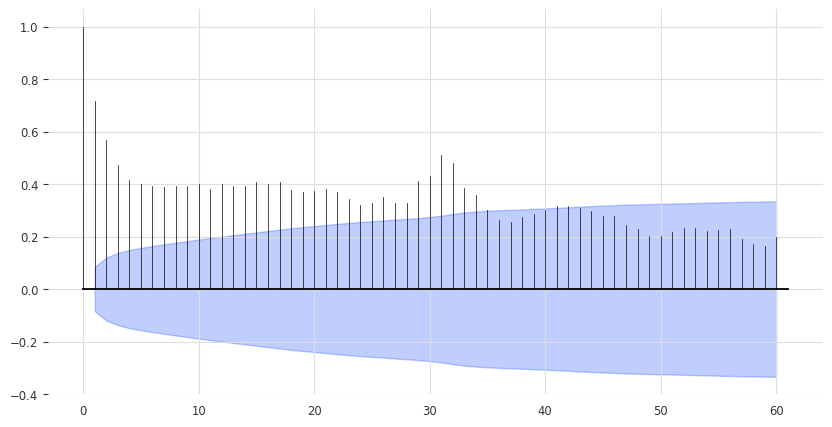

In [5]:
# Plot stationary and also the seasonality using ACF and PACF plots
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_pacf

#test stationary with autocorrelation function
plot_acf(series, max_lag=60)
plt.show()

#กรณีข้อมูลเป็น Stationary จุดในแกน X (lags) มีค่า Y เป็น 0 หรือใกล้เคียง(ค่า Correlation -1,1)

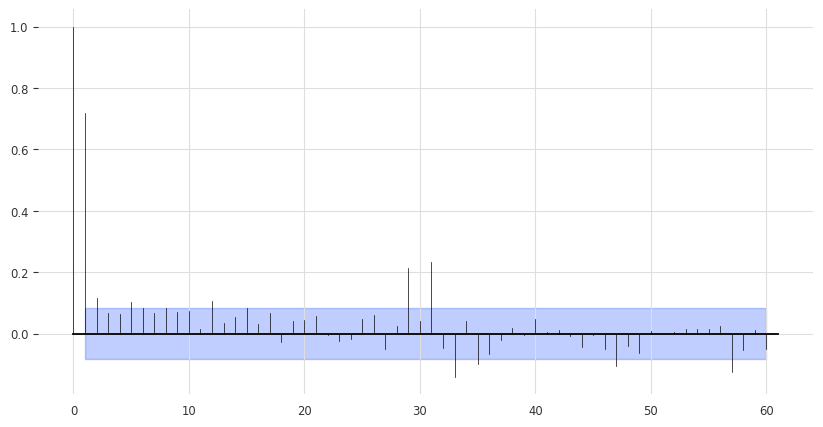

In [6]:
plot_pacf(series, max_lag=60)
plt.show()

In [12]:
# stationary test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["unique_order_count"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
#https://machinelearningmastery.com/time-series-data-stationary-python/

ADF Statistic: -2.984690
p-value: 0.036349


### Training Test Split

### Feature Engineering

In [8]:
# Function to replace outliers with the mean of the rest of the values
from scipy.stats import zscore
from darts import TimeSeries

def replace_outliers_with_mean(df, column_name):
    # Calculate Z-scores
    z_scores = zscore(df[column_name])
    
    # Identify outliers (using a threshold of 3 for Z-score)
    outliers = np.abs(z_scores) > 3
    
    # Calculate mean of non-outliers
    mean_non_outliers = df.loc[~outliers, column_name].mean()
    
    # Replace outliers with the mean of non-outliers
    df.loc[outliers, column_name] = mean_non_outliers
    
    return df

# Replace outliers in 'gmv' column
df_remove_out = replace_outliers_with_mean(df, 'unique_order_count')
series_remove_outlier = TimeSeries.from_dataframe(df_remove_out,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                   freq="D")
series = series_remove_outlier #!!!

C:\Users\User\AppData\Local\Temp\ipykernel_17312\3762271405.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '142.51486988847583' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers, column_name] = mean_non_outliers


In [9]:
from darts.dataprocessing.transformers import (Scaler,)

scaler = Scaler()
series_rescaled = scaler.fit_transform(series)
series = series_rescaled

### Split test

In [10]:
# training, validation =series.split_before(pd.Timestamp('2024-01-01'))
cut_off = pd.Timestamp("2024-05-01")
# cut_off = pd.Timestamp("2024-05-01")

training, validation =series.split_before(cut_off)
# training, validation =series.split_before(pd.Timestamp('2024-04-01')) # 2 month
# training, validation =series.split_before(pd.Timestamp('2024-05-01')) # 1 month

In [11]:
#check date split
validation_df = validation.pd_dataframe()
training_df = training.pd_dataframe()
print(training_df.tail())
print(validation_df.head())

component           unique_order_count
order_completed_at                    
2024-04-26                    0.265347
2024-04-27                    0.207921
2024-04-28                    0.251485
2024-04-29                    0.229703
2024-04-30                    0.251485
component           unique_order_count
order_completed_at                    
2024-05-01                    0.231683
2024-05-02                    0.342574
2024-05-03                    0.261386
2024-05-04                    0.255446
2024-05-05                    0.350495


In [12]:
print(training_df.shape)
print(validation_df.shape)

(486, 1)
(62, 1)


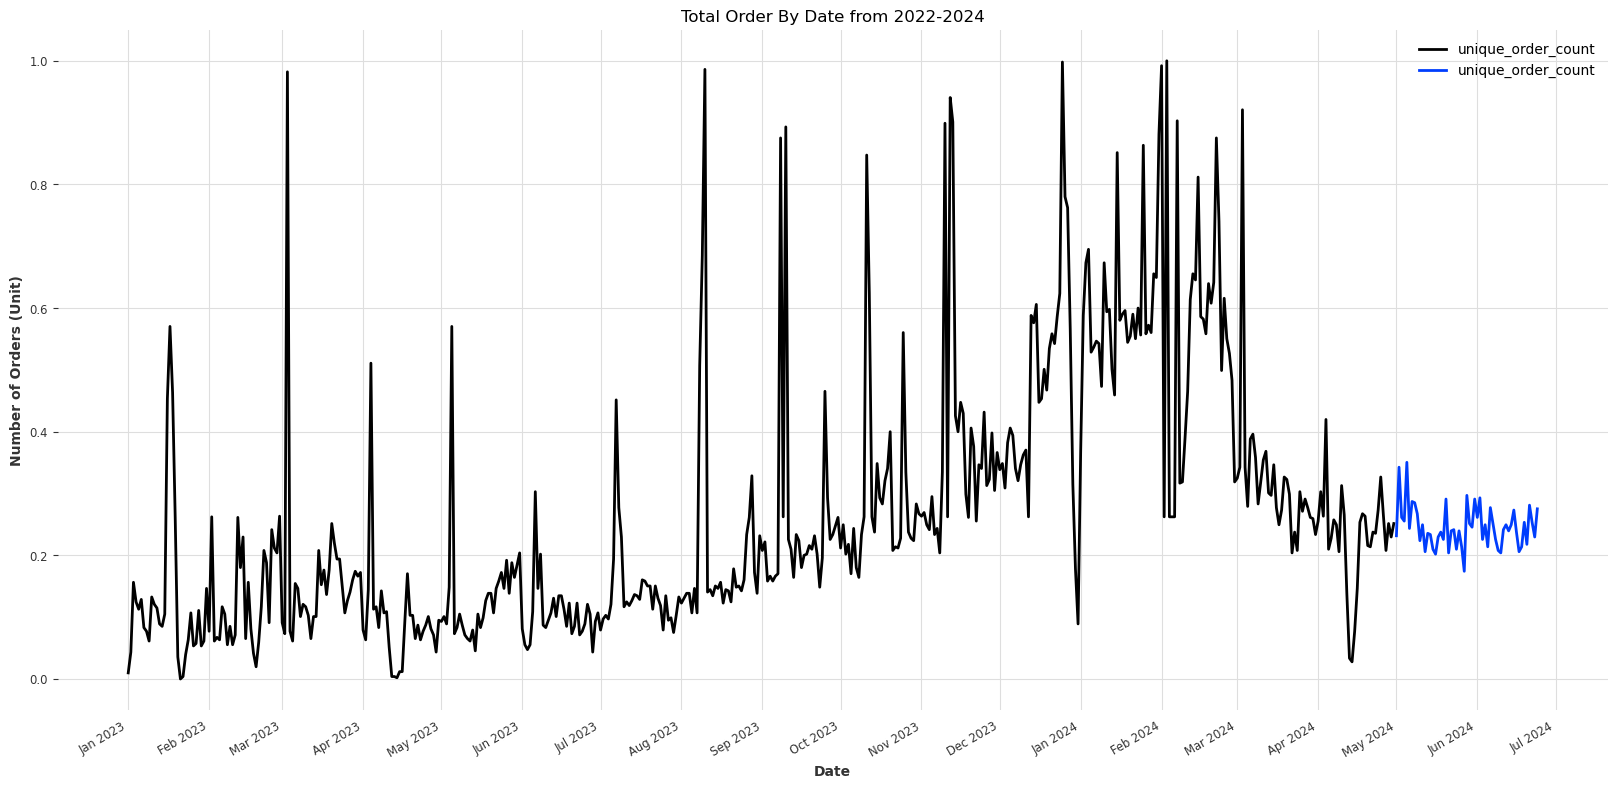

In [102]:
import matplotlib.dates as mdates

plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)
training.plot()
validation.plot()

# ตั้งค่ารูปแบบของวันที่บนแกน x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # ปรับให้วันที่ไม่ซ้อนกัน

# กำหนด Title และชื่อของแกน x และ y
plt.title('Total Order By Date from 2022-2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders (Unit)')

plt.show()

# Feature Engineering

In [25]:
# Feature Engineering is limited and hard to do, so skip

# Modeling

### LinearRegression Model

In [12]:
from darts.models import LinearRegressionModel

model = LinearRegressionModel(lags=14, output_chunk_length=7, random_state=42) # must at least input lags
model.fit(training)
forecast = model.predict(len(validation))

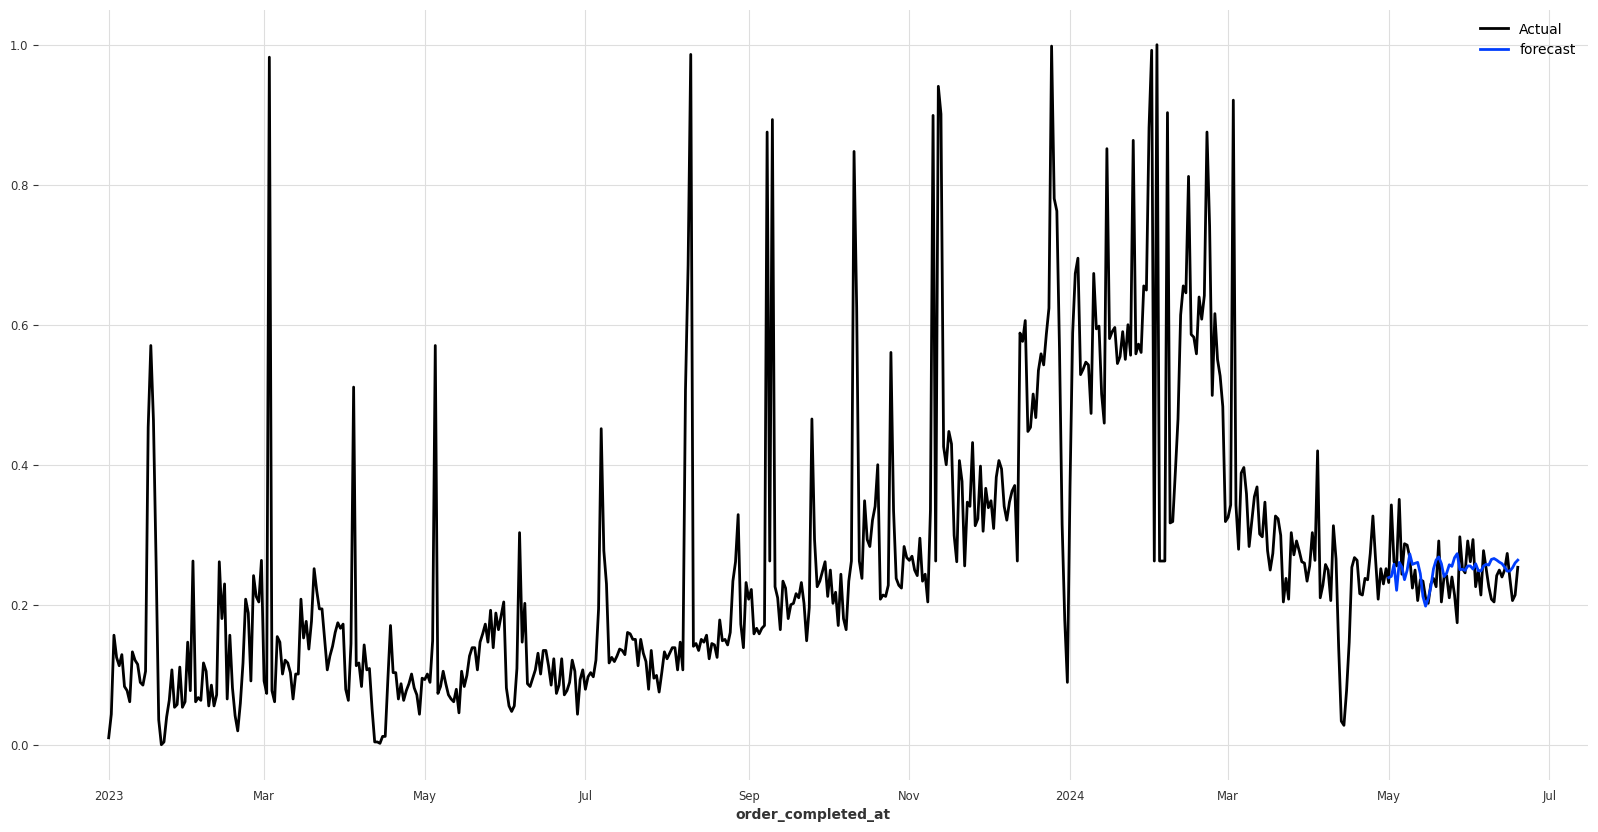

In [13]:
# plot Actual and Predict
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))  
series.plot(label="Actual")
forecast.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

### Metric to Evaluate Model

In [14]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt
#not recommendation

mape_score = mape(validation, forecast)
print(f'score MAPE: {mape_score}')

mase_score = mase(validation, forecast, training)
print(f'score MASE: {mase_score}')

score MAPE: 11.871603992608495
score MASE: 0.3419448984021449


### Evaluating Model Performance 
historical_forecast() and backtest()

In [ ]:
# historical forecast not found, only backtesting

backtest_errors = model.backtest(
     series,
     start=pd.Timestamp("2024-05-01"),          # เริ่มต้นที่ 80% ของข้อมูล
     forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
     stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
     last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่ , เพราะต้องการแค่ทำนายวันพรุ่งนี้
     metric=mape,
     reduction=np.mean           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
)

In [131]:
print(f'backtest_errors MAPE: {round(backtest_errors,2)}%')

backtest_errors MAPE: 12.1%


In [ ]:
# historical forecast not found, only backtesting

backtest_errors = model.backtest(
     series,
     start=pd.Timestamp("2024-0-01"),          # เริ่มต้นที่ 80% ของข้อมูล
     forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
     stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
     last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่ , เพราะต้องการแค่ทำนายวันพรุ่งนี้
     metric=mse,
     reduction=np.mean           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
)

In [ ]:
print(f'backtest_errors MAPE: {round(backtest_errors,2)}%')

# Tuning , Find Best Hyperparameter

### GridSearch

In [ ]:
# Making a parameter dictionary for use in the gridsearch function
# Gridsearch will return the best model that hasn't been trained yet.
from darts.models import LinearRegressionModel
from darts.metrics import mape, mae, mse, mase
from math import sqrt

parameters = {
    "lags": list(range(1, 36)),
    "output_chunk_length": [7],
    "random_state": [42]
}

best_parameter = LinearRegressionModel.gridsearch(
    parameters=parameters,
    series = series, #note (training + validation) X only training set!!!
    start=0.8,
    forecast_horizon=7,
    stride=1,          
    last_points_only=False,  
    metric=mse,
    verbose=-1
)

In [144]:
print(best_parameter[0])
print(best_parameter[1])
print(f'MSE: {best_parameter[2]}')
parameters_in = best_parameter[1].copy()
print(parameters_in['lags'])

LinearRegression()
{'lags': 4, 'output_chunk_length': 7, 'random_state': 42}
MSE: 0.003302531061386567
4


In [17]:
from darts.models import LinearRegressionModel

# fit best model
# best_model = best_parameter[0]
best_model = LinearRegressionModel(lags=14, output_chunk_length=7, random_state=42)
best_model.fit(training)

LinearRegressionModel(lags=14, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True)

In [20]:
from darts.models import LinearRegressionModel
from darts.metrics import mape, mae, mse, mase
from math import sqrt

# result from training , validation only
prediction = best_model.predict(len(validation))

# validation = scaler.inverse_transform(validation)
# prediction = scaler.inverse_transform(prediction)

mape_score = mape(validation, prediction)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation, prediction)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation, prediction)
print(f'score MAE: {round(mae_score, 4)}')

score MAPE: 12.7744
score ACC: 87.2256
score MSE: 0.0014
score RMSE: 0.037
score MAE: 0.0302


### rescaled train validation evaluate

In [21]:
validation_rescale = scaler.inverse_transform(validation)
prediction_rescale = scaler.inverse_transform(prediction)

mape_score = mape(validation_rescale, prediction_rescale)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation_rescale, prediction_rescale)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation_rescale, prediction_rescale)
print(f'score MAE: {round(mae_score, 4)}')

score MAPE: 11.7626
score ACC: 88.2374
score MSE: 348.8921
score RMSE: 18.6787
score MAE: 15.2458


In [29]:
# from darts.metrics import mape, mae, mse, mase
# from math import sqrt

# backtest_errors = best_model.backtest(
#      series,
#      start=0.9,          # เริ่มต้นที่ 90% ของข้อมูล
#      forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
#      stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
#      last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
#      metric=mse,
#      reduction=np.mean           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
# )
# print(f'backtest_errors mse: {backtest_errors}')

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


backtest_errors mse: 0.0013551478537515624


In [35]:
# from darts.metrics import mape, mae, mse, mase
# from math import sqrt

# backtest_errors = best_model.backtest(
#      scaler.inverse_transform(series),
#      start=0.8,          # เริ่มต้นที่ 90% ของข้อมูล
#      forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
#      stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
#      last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
#      metric=mape,
#      reduction=np.mean           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
# )
# print(f'backtest_errors mse: {backtest_errors}')

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


backtest_errors mse: 22.978927544316353


In [ ]:
# linear reg , 4 lags , 80%split => mse:842.227, mape:22.97

### mse

In [21]:
training, validation =series.split_before(pd.Timestamp('2024-05-01')) # 1 month

In [22]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt
from darts.models import LinearRegressionModel

training, validation =series.split_before(pd.Timestamp('2024-05-01')) # 1 month

best_model = LinearRegressionModel.load("../model/linearRegressionModel_totalOrder_25Jun67_28lags.pkl")
backtest_errors = best_model.backtest(
     series,
     start=pd.Timestamp('2024-05-01'),          # เริ่มต้นที่ 90% ของข้อมูล
     forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
     stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
     last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
     metric=mse,
     reduction=np.mean           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
)
print(f'backtest_errors MSE: {backtest_errors}')

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


backtest_errors MSE: 352.4980507229939


In [37]:
# result from training , validation only
prediction = best_model.predict(len(validation))

mape_score = mape(validation, prediction)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation, prediction)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation, prediction)
print(f'score MAE: {round(mae_score, 4)}')


score MAPE: 13.4896
score ACC: 86.5104
score MSE: 0.0015
score RMSE: 0.0382
score MAE: 0.0316


In [ ]:
# result from training , validation only
prediction = best_model.predict(len(validation))

mape_score = mape(validation, prediction)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation, prediction)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation, prediction)
print(f'score MAE: {round(mae_score, 4)}')

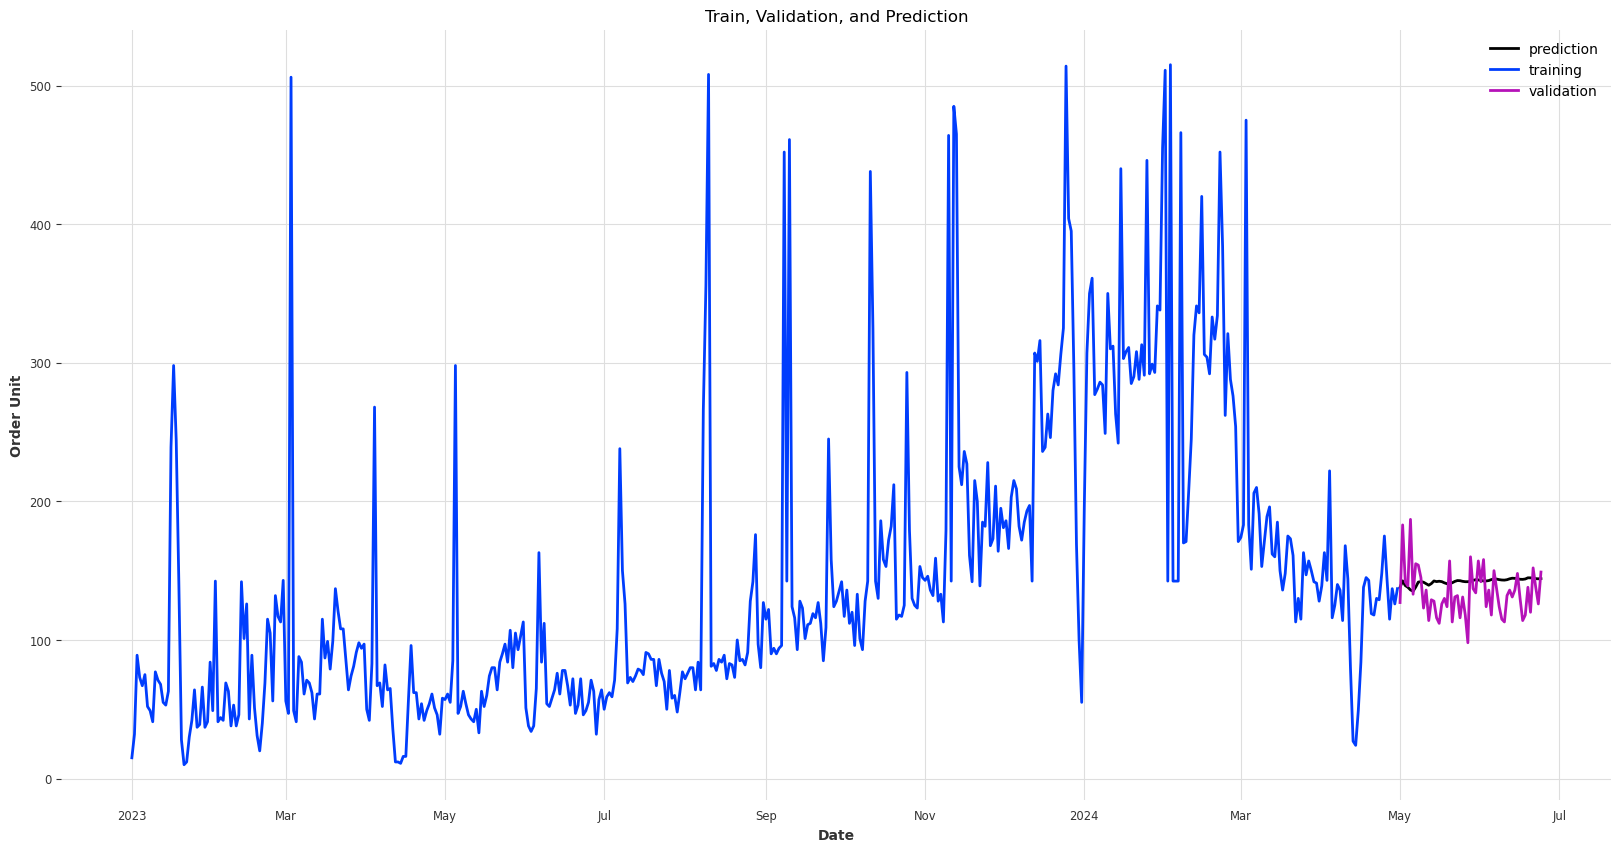

In [76]:
plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)
##prediction
prediction.plot(label="prediction")
training.plot(label="training")
validation.plot(label="validation")

plt.legend()
plt.title('Train, Validation, and Prediction')
plt.xlabel('Date')
plt.ylabel('Order Unit')
plt.show()

In [22]:
# predict future
best_model.fit(series)


LinearRegressionModel(lags=14, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True)

In [26]:
#check date
series.pd_dataframe().tail(14)

component,unique_order_count
order_completed_at,
2024-06-11,0.241584
2024-06-12,0.249505
2024-06-13,0.239604
2024-06-14,0.249505
2024-06-15,0.273267
2024-06-16,0.237624
2024-06-17,0.205941
2024-06-18,0.213861
2024-06-19,0.253465


In [23]:
forecast = best_model.predict(7)
forecast  = scaler.inverse_transform(forecast)
forecast = forecast.pd_dataframe().reset_index()
forecast.columns = ['Date', 'Total Order']
print(forecast.tail(7))

forecast.tail(7).to_csv('../forecast/25-06-67_linear_1month.csv', index=False)

        Date  Total Order
0 2024-07-02   145.006623
1 2024-07-03   142.883255
2 2024-07-04   144.689374
3 2024-07-05   140.629480
4 2024-07-06   140.500536
5 2024-07-07   140.048832
6 2024-07-08   140.679852


### save model

In [24]:
#from darts.models import LinearRegressionModel, Prophet

best_model.save("../model/linearRegressionModel_totalOrder_1Jul67_14lags.pkl")
# model_loaded = LinearRegressionModel.load("model/linearRegressionModel_totalOrder_12Jun67.pkl")